In [68]:
from huggingface_hub import hf_hub_download
from datasets import load_dataset
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from sklearn_extra.cluster import KMedoids
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import gensim
import pickle

In [5]:
df = pd.read_pickle('../data/tifu_cleaned.pkl')

## Clustering


### Defining needed functions

In [54]:
# Visualization
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=2).fit_transform(data_subset)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data_subset))

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('t-SNE Cluster Plot')

def plot_3d_pca_tsna(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :].todense())

    pca = PCA(n_components=3).fit_transform(data_subset)
    tsne = TSNE(n_components=3).fit_transform(data_subset)

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f = plt.figure(figsize=(18, 8))
    
    # 3D PCA Plot
    ax1 = f.add_subplot(121, projection='3d')
    ax1.scatter(pca[idx, 0], pca[idx, 1], pca[idx, 2], c=label_subset)
    ax1.set_title('3D PCA Cluster Plot')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')

    # 3D t-SNE Plot
    ax2 = f.add_subplot(122, projection='3d')
    ax2.scatter(tsne[idx, 0], tsne[idx, 1], tsne[idx, 2], c=label_subset)
    ax2.set_title('3D t-SNE Cluster Plot')
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    ax2.set_zlabel('t-SNE Dimension 3')

    plt.show()

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    silhouette_scores = []
    
    for k in iters:
        kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
        kmeans.fit(data)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        
        print(f'Fit {k} clusters - Silhouette Score: {silhouette_avg}')
        
    # Plot silhouette scores
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouette_scores, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score by Cluster Center Plot')

    
def get_top_keywords(data, clusters, feature_names, n_terms):
    df = pd.DataFrame(np.asarray(data.todense())).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([feature_names[t] for t in np.argsort(r)[-n_terms:]]))

In [42]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=4353,
    stop_words='english'
)


text_tfidf = tfidf.fit_transform(df['documents'])
text_tfidf_title = tfidf.fit_transform(df['title'])

#### Finding optimal clusters 

Fit 2 clusters - Silhouette Score: 0.0029466455494314924


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.0020058700448387606


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.0024681888729672628


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: -9.629962285889297e-06


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.0021565730785297562


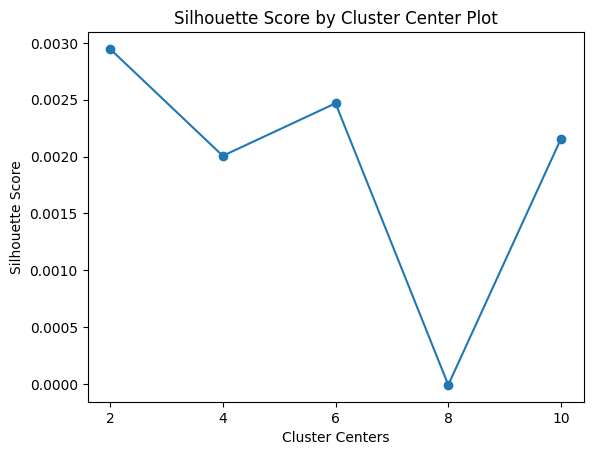

In [57]:
# Find optimal clusters
find_optimal_clusters(text_tfidf, 10)

In [48]:
# Clustering using MiniBatchKMeans
optimal_clusters = 6  # Adjust based on your findings
clusters_tfidf = MiniBatchKMeans(n_clusters=optimal_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_tfidf)
clusters_kmedoids = KMedoids(n_clusters=optimal_clusters, metric='cosine', random_state=20).fit_predict(text_tfidf)

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### KMeedoids Clustering

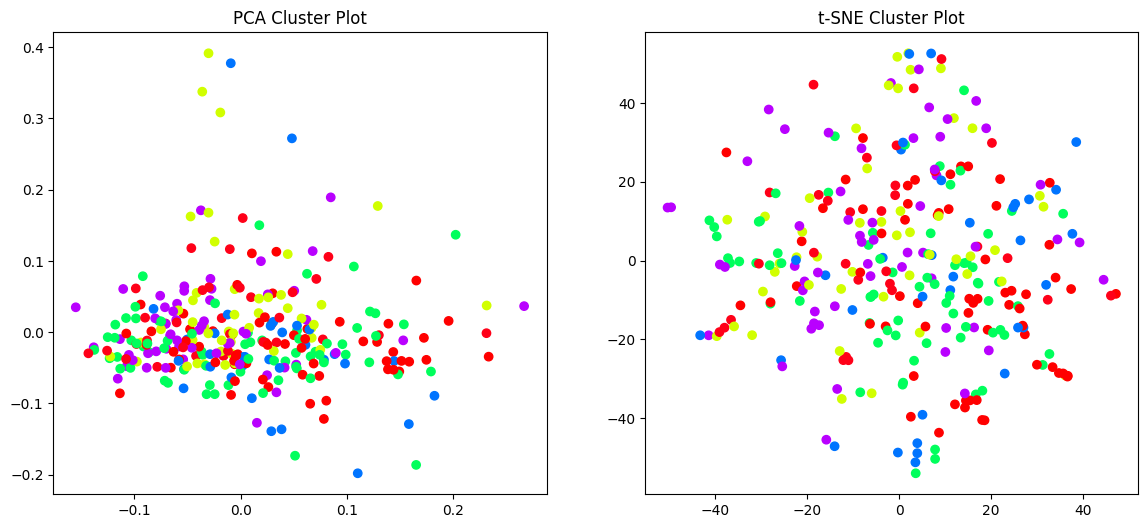

In [60]:
# Plotting PCA and t-SNE
plot_tsne_pca(text_tfidf, clusters_kmedoids)
plt.show()

#### KMeans Clustering

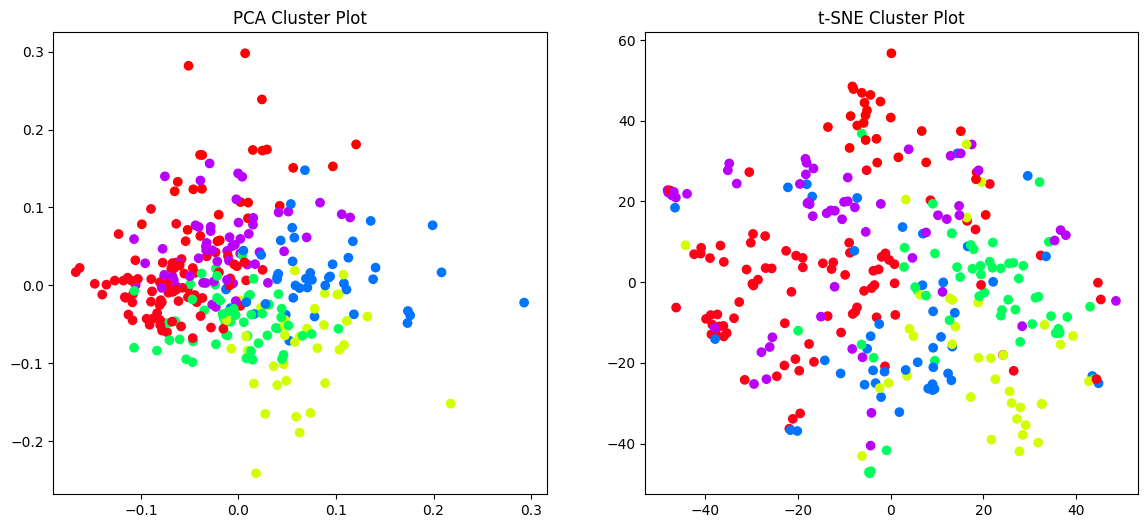

In [50]:
# Plotting PCA and t-SNE
plot_tsne_pca(text_tfidf, clusters_tfidf)
plt.show()

In [100]:
get_top_keywords(text_tfidf, clusters_tfidf, tfidf.get_feature_names_out(), 5)


Cluster 0
dried,resulted,jewish,dreaming,careful

Cluster 1
free,freak,team,chunks,sale

Cluster 2
toe,golfing,jewish,woke,partner

Cluster 3
times,question,gf,lending,jewish

Cluster 4
benefits,jewish,hottest,review,dmv

Cluster 5
golfing,omegle,war,jewish,lending


In [101]:
get_top_keywords(text_tfidf, clusters_kmedoids, tfidf.get_feature_names_out(), 5)


Cluster 0
lending,jewish,question,golfing,sale

Cluster 1
friendship,fridge,lending,jewish,partner

Cluster 2
golfing,desktop,roommate,lending,jewish

Cluster 3
times,careful,lending,jewish,freak

Cluster 4
times,vacuum,careful,jewish,woke

Cluster 5
hottest,bragging,freak,bee,jewish


#### Assign clusters

In [51]:
df['cluster'] = clusters_tfidf

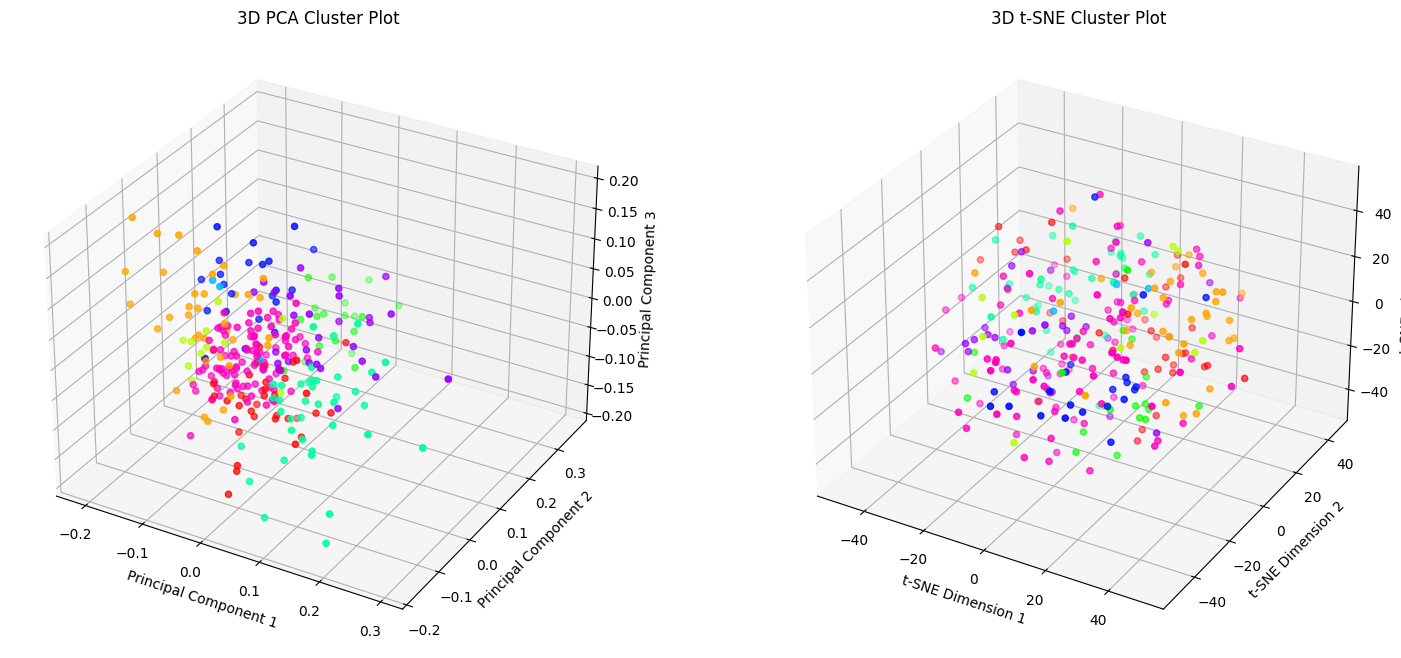

In [39]:
# Call the 3D PCA plot function
plot_3d_pca_tsna(text_tfidf, clusters_tfidf)
#plot_3d_pca_tsna(text_tfidf, clusters_tfidf)

## Word Embedding

In [62]:
tokenized_sentences = [sentence.split() for sentence in df['documents']]
model = word2vec.Word2Vec(tokenized_sentences,  vector_size=20, window=5, min_count=1, workers=10)

print(model)


Word2Vec<vocab=308263, vector_size=20, alpha=0.025>


In [63]:
embeddings = [np.mean([model.wv[word] for word in doc], axis=0) for doc in tokenized_sentences]


In [69]:
data_standardized = StandardScaler().fit_transform(embeddings)



In [85]:
clusters_kmeans = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(data_standardized)



c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [90]:
embeddings

[array([ 0.03057311,  1.160894  ,  1.5445924 ,  1.5358539 , -1.0659372 ,
        -0.05622641,  1.4120531 ,  0.527322  ,  0.56956774,  0.25217915,
        -1.926997  ,  0.525084  , -1.7473539 ,  0.08397873,  1.470668  ,
         0.34503272,  0.88612896, -0.10759737,  1.0233513 ,  0.33331305],
       dtype=float32),
 array([ 0.3999585 ,  1.4298286 ,  1.2414726 ,  2.1005816 , -2.519125  ,
        -0.22142863,  1.6915112 ,  0.31356838,  1.2081381 , -0.05502638,
        -1.5587722 ,  0.5608225 , -2.2839725 ,  0.12928787,  1.7508107 ,
         0.601942  ,  0.57950366,  0.0171643 ,  0.42742127,  1.0564595 ],
       dtype=float32),
 array([-0.29874682,  0.59198284,  1.8115667 ,  0.8101963 , -1.806497  ,
        -0.40678   ,  2.075531  ,  0.81722367,  0.56656486, -0.07974981,
        -2.0530934 ,  0.5388436 , -2.0873978 , -0.32082886,  1.300232  ,
         0.56421053,  0.72957844, -0.80711526,  0.3523692 ,  0.9387037 ],
       dtype=float32),
 array([ 0.22245544,  0.20368065,  1.8473011 ,  0.65

In [96]:
def plot_tsne_pca_emb(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :])

    n_components_pca = min(data_subset.shape[0], data_subset.shape[1])  # Adjusted line
    pca = PCA(n_components=n_components_pca).fit_transform(data_subset)
    
    tsne = TSNE().fit_transform(pca)  # Use PCA output for t-SNE

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('t-SNE Cluster Plot')

def plot_3d_pca_tsna_emb(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(len(data)), size=3000, replace=False)

    data_subset = np.asarray(data[max_items, :])

    # 3D PCA
    pca = PCA(n_components=3).fit_transform(data_subset)

    # 3D t-SNE
    tsne = TSNE(n_components=3).fit_transform(data_subset)

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [plt.cm.hsv(i / max_label) for i in label_subset[idx]]

    f = plt.figure(figsize=(18, 8))

    # 3D PCA Plot
    ax1 = f.add_subplot(121, projection='3d')
    ax1.scatter(pca[idx, 0], pca[idx, 1], pca[idx, 2], c=label_subset)
    ax1.set_title('3D PCA Cluster Plot')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')

    # 3D t-SNE Plot
    ax2 = f.add_subplot(122, projection='3d')
    ax2.scatter(tsne[idx, 0], tsne[idx, 1], tsne[idx, 2], c=label_subset)
    ax2.set_title('3D t-SNE Cluster Plot')
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    ax2.set_zlabel('t-SNE Dimension 3')

    plt.show()

In [94]:
embeddings_np = np.array(embeddings)

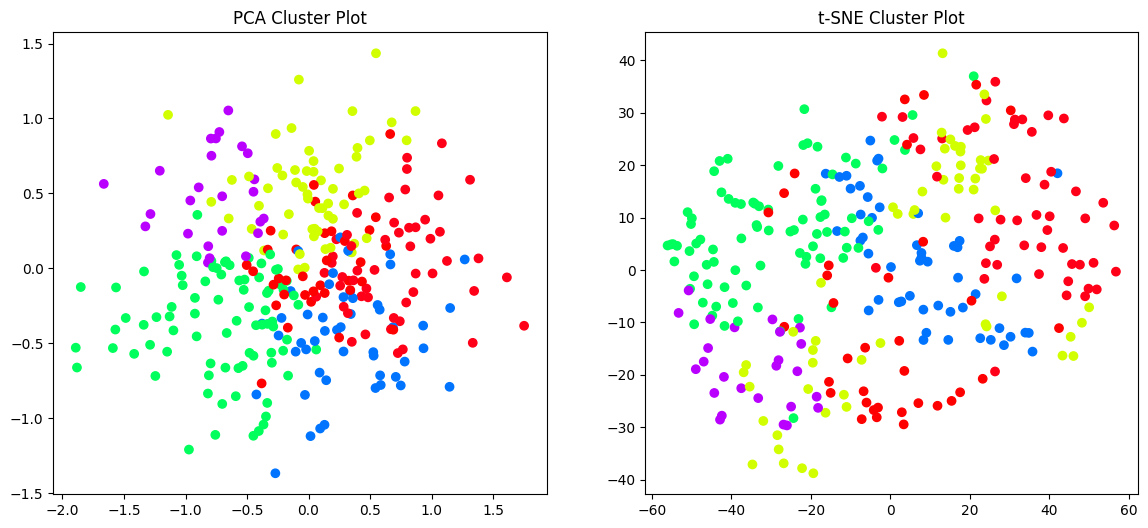

In [95]:
# Plotting PCA and t-SNE
plot_tsne_pca_emb(embeddings_np, clusters_kmeans)
plt.show()

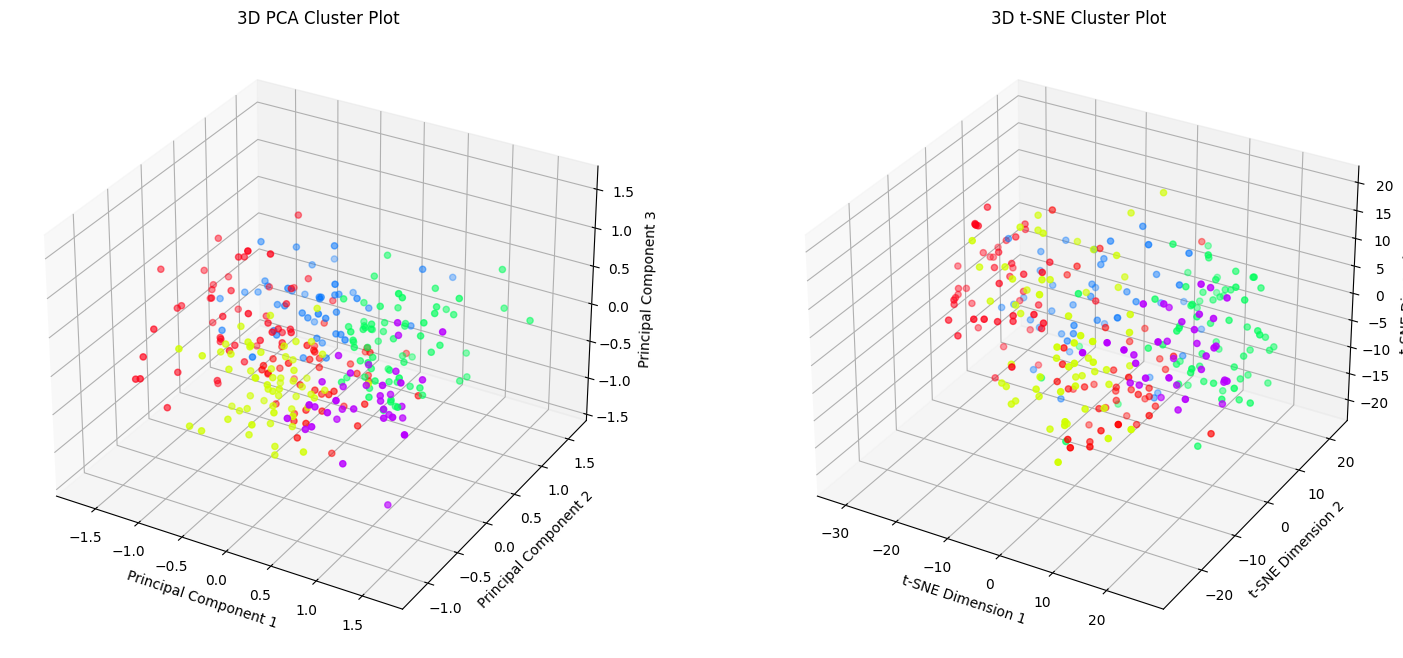

In [97]:
plot_3d_pca_tsna_emb(embeddings_np, clusters_kmeans)
plt.show()

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters - Silhouette Score: 0.09977070838065276


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.06385353507565042


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.052652167804593836


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: 0.04830299888699646


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.04647113902834606


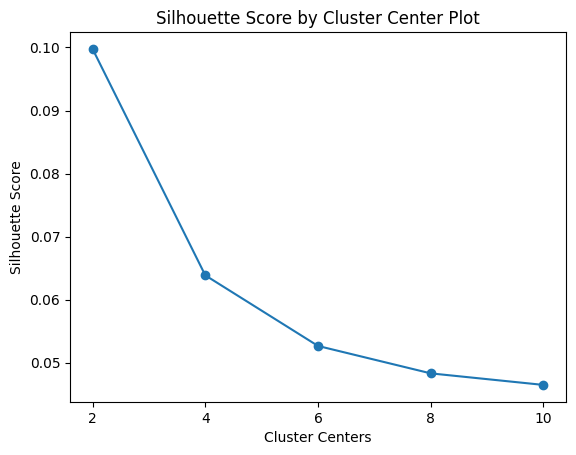

In [78]:
def find_optimal_clusters_with_embeddings(tokenized_text, max_k):
    # Train Word2Vec model
    word2vec_model = word2vec.Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

    # Get embeddings for each document
    embeddings = [np.mean([word2vec_model.wv[word] for word in doc], axis=0) for doc in tokenized_text]

    # Standardize the embeddings
    data_standardized = StandardScaler().fit_transform(embeddings)

    iters = range(2, max_k+1, 2)
    
    silhouette_scores = []
    
    for k in iters:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=20)
        kmeans.fit(data_standardized)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data_standardized, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        
        print(f'Fit {k} clusters - Silhouette Score: {silhouette_avg}')
        
    # Plot silhouette scores
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouette_scores, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score by Cluster Center Plot')

# Example usage:
# Assuming 'tokenized_text' is a list of tokenized sentences
find_optimal_clusters_with_embeddings(tokenized_sentences, max_k=10)